# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, PrecisionRecallDisplay

import warnings
warnings.filterwarnings("ignore")

import shap
shap.initjs()

pd.set_option('display.max_columns', None)

# Загрузка и предобработка данных

In [2]:
df = pd.read_csv('data_seeds.csv')
df

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
0,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...
205,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [17]:
data_columns = df.columns[:-1]
cat_columns = []
labels = df.columns[-1]

X = df[data_columns]
y = df[labels] # Общий случай, многоклассовый
#y = (df[labels] == 1).astype(int) # Упрощение до бинарного

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение модели и вывод результатов

## Бинарная классификация

### Обучение модели для бинарной классификации

In [16]:
model = CatBoostClassifier(random_seed=7, iterations=500, learning_rate=0.01, depth=6, loss_function='Logloss', cat_features=cat_columns, scale_pos_weight=(len(y) - y.sum()) / y.sum())
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Сохранение и загрузка модели

In [ ]:
model.save_model('catboost_model.json')
model.save_model('catboost_model.bin')

In [ ]:
model = CatBoostClassifier(cat_features=cat_columns)
model.load_model('catboost_model.bin')
model.get_params()

### Результаты

In [5]:
threshold = 0.5      #Решающий порог

y_pred = model.predict_proba(X_test)
y_pred = (y_pred[:, 1] >= threshold)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.951     0.907     0.929        43
           1      0.818     0.900     0.857        20

    accuracy                          0.905        63
   macro avg      0.885     0.903     0.893        63
weighted avg      0.909     0.905     0.906        63



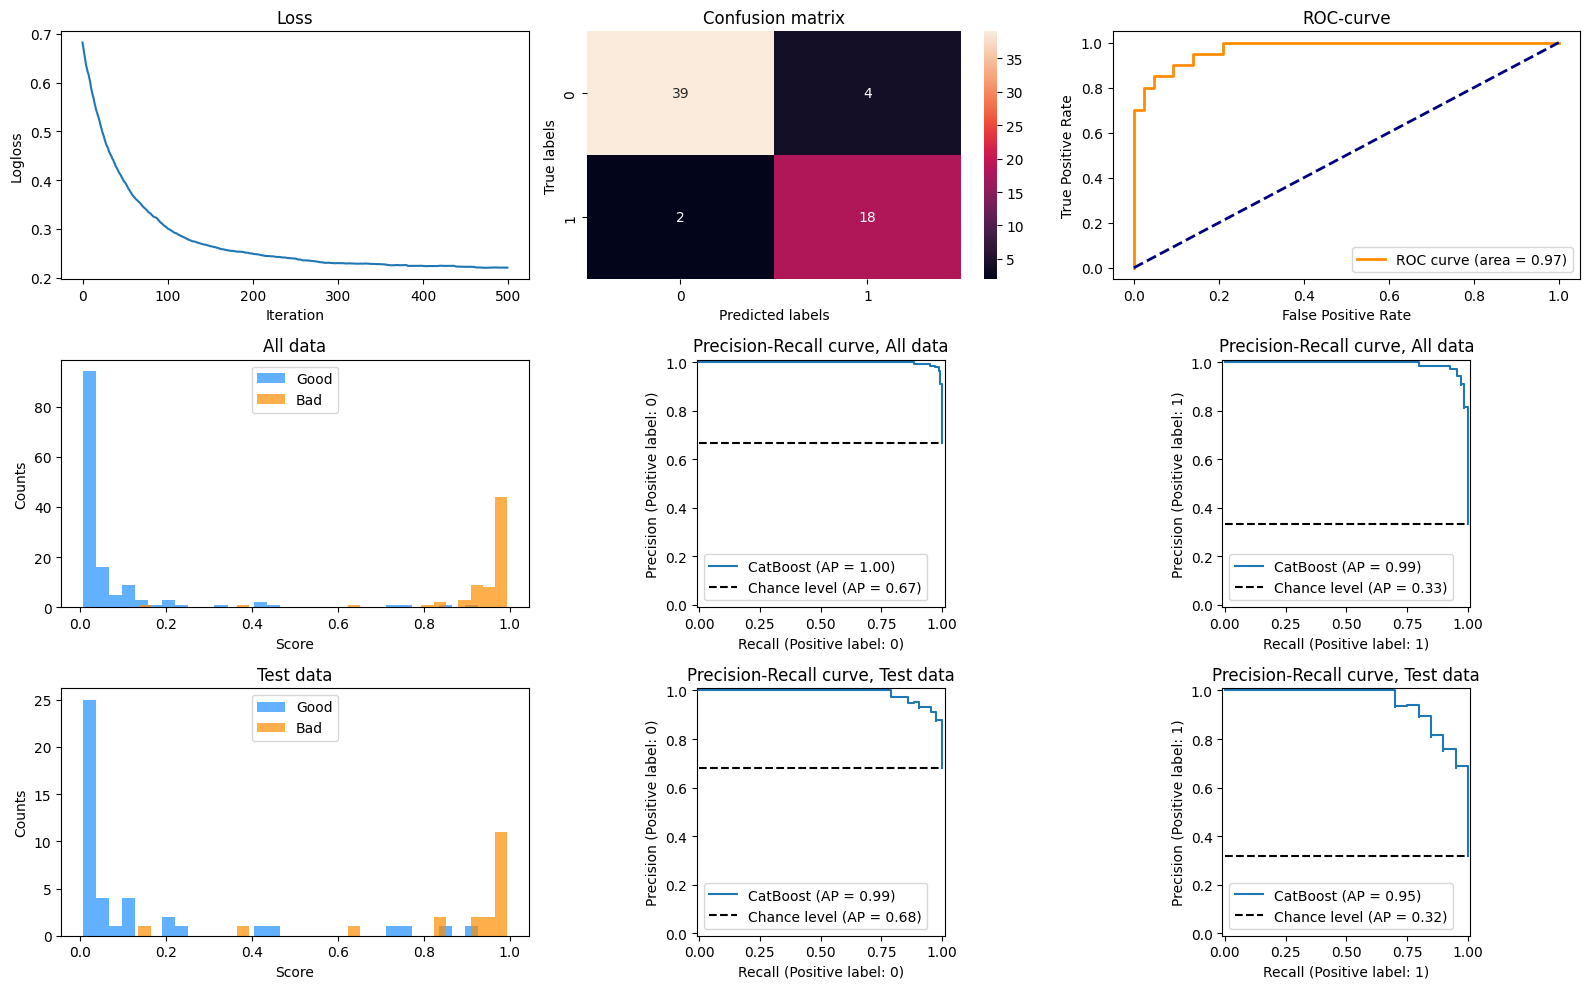

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

axs[0, 0].plot(model.evals_result_['validation']['Logloss'])
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Logloss')
axs[0, 0].set_title('Loss')


A = model.predict_proba(X)[:, 1]
B = y.to_numpy()
class_0 = np.array([A[i] for i in range(len(A)) if B[i] == 0])
class_1 = np.array([A[i] for i in range(len(A)) if B[i] == 1])
axs[1, 0].hist(class_0, alpha=0.7, label='Good', color="dodgerblue", bins=30)
axs[1, 0].hist(class_1, alpha=0.7, label='Bad', color='darkorange', bins=30)
axs[1, 0].set_xlabel('Score')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_title('All data')
axs[1, 0].legend(loc='upper center')


A = model.predict_proba(X_test)[:, 1]
B = y_test.to_numpy()
class_0 = np.array([A[i] for i in range(len(A)) if B[i] == 0])
class_1 = np.array([A[i] for i in range(len(A)) if B[i] == 1])
axs[2, 0].hist(class_0, alpha=0.7, label='Good', color="dodgerblue", bins=30)
axs[2, 0].hist(class_1, alpha=0.7, label='Bad', color='darkorange', bins=30)
axs[2, 0].set_xlabel('Score')
axs[2, 0].set_ylabel('Counts')
axs[2, 0].set_title('Test data')
axs[2, 0].legend(loc='upper center')


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axs[0, 1])
axs[0, 1].set_xlabel('Predicted labels')
axs[0, 1].set_ylabel('True labels')
axs[0, 1].set_title('Confusion matrix')


fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
axs[0, 2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0, 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0, 2].set_xlabel('False Positive Rate')
axs[0, 2].set_ylabel('True Positive Rate')
axs[0, 2].legend(loc='lower right')
axs[0, 2].set_title('ROC-curve')


display = PrecisionRecallDisplay.from_estimator(model, X, y, name="CatBoost", plot_chance_level=True, pos_label=0, ax=axs[1, 1])
_ = display.ax_.set_title("Precision-Recall curve, All data")
display = PrecisionRecallDisplay.from_estimator(model, X, y, name="CatBoost", plot_chance_level=True, pos_label=1, ax=axs[1, 2])
_ = display.ax_.set_title("Precision-Recall curve, All data")


display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="CatBoost", plot_chance_level=True, pos_label=0, ax=axs[2, 1])
_ = display.ax_.set_title("Precision-Recall curve, Test data")
display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="CatBoost", plot_chance_level=True, pos_label=1, ax=axs[2, 2])
_ = display.ax_.set_title("Precision-Recall curve, Test data")


plt.tight_layout()
plt.show()


### Интерпретация

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X, y)

In [13]:
shap.plots.force(shap_values[70], link="logit")

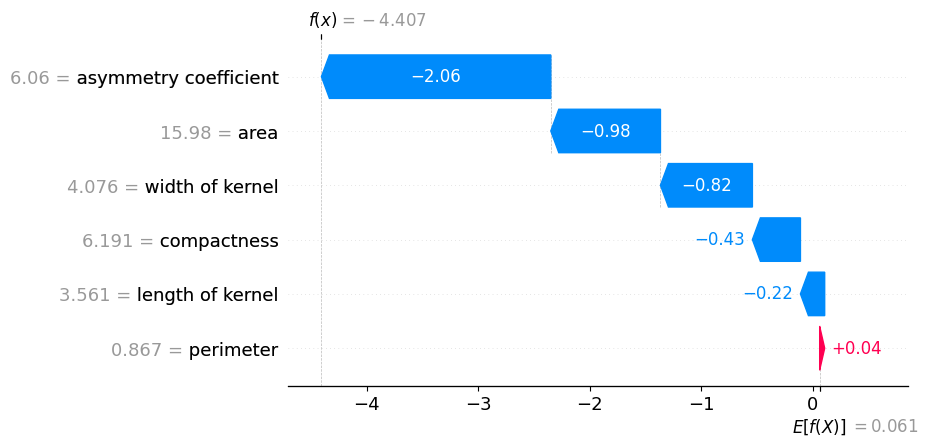

In [14]:
shap.plots.waterfall(shap_values[70])

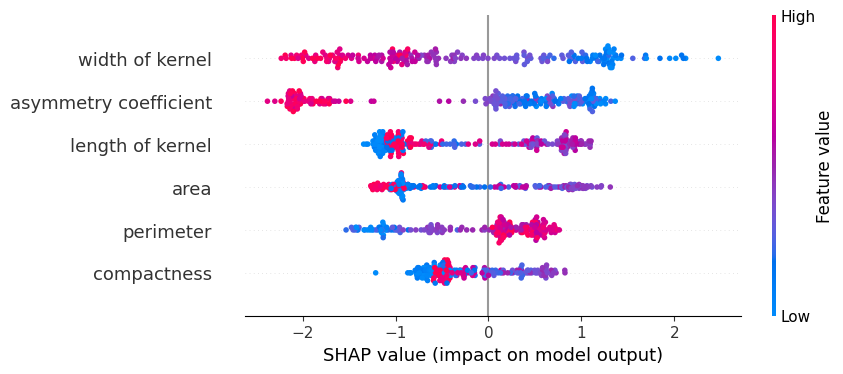

In [15]:
shap.plots.beeswarm(shap_values, max_display=10)

## Мультиклассовая классификация

### Обучение модели для мультиклассовой классификации

In [18]:
model = CatBoostClassifier(random_seed=42, iterations=500, learning_rate=0.01, depth=6, loss_function='MultiClass', cat_features=cat_columns)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Результаты 

In [19]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.818     0.900     0.857        20
           2      1.000     0.952     0.976        21
           3      0.905     0.864     0.884        22

    accuracy                          0.905        63
   macro avg      0.908     0.905     0.905        63
weighted avg      0.909     0.905     0.906        63



Данный раздел будет дополняться, результаты работы классификатора и интерпретация для мультиклассовой модели будут добавлены позже

### Интерпретация

# Важность признаков

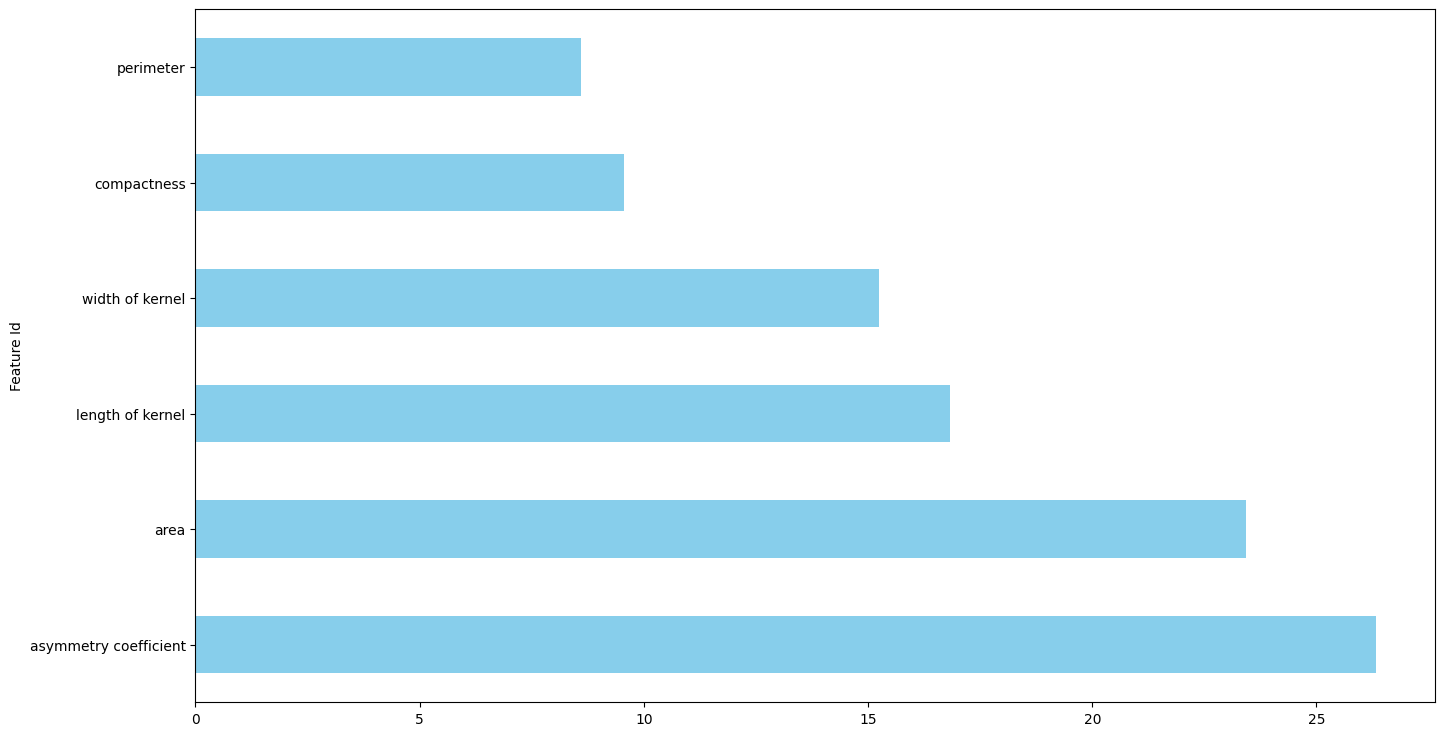

In [22]:
Z = model.get_feature_importance(prettified=True)

Z.plot(x='Feature Id', y='Importances', kind='barh', legend=None, color='skyblue', figsize=(16, 9))
plt.show()